## Imports

In [3]:
import scipy.io as sio
import numpy as np
import sklearn
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from skimage.io import imread
from scipy import stats
%matplotlib inline

## Load the Data [Images]

In [ ]:
# Load Data Here

## Code

### Helper Functions

In [5]:
def plot(im, img, k=0, image=False, ylabel='', xlabel='', axis=False):
    if image:
        fig = plt.figure()
        a=fig.add_subplot(1,2,1)
        imgplot = plt.imshow(im,cmap='gray')
        a.set_title('Before')
        a=fig.add_subplot(1,2,2)
        imgplot = plt.imshow(img, cmap='gray')
        a.set_title("After [k = "+str(k)+"]")
    else:
        plt.plot(im, img, 'ro')
        if type(axis) != bool:
            plt.axis(axis)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.show()
        
def make_val_set(V):
    M = np.empty((100, 100))
    M[:] = np.NAN
    for x in V:
        i = x[0] - 1
        j = x[1] - 1 
        M[i][j] = x[2]
    return M

def make_pred_2(M):
    G = np.zeros(M.shape)
    for i in range(len(M)):
        if M[i] >= 0:
            G[i] = 1
    return G

def make_pred(M):
    G = np.zeros(M.shape)
    for i in range(len(M)):
        for j in range(M.shape[1]):
            if M[i][j] >= 0:
                G[i][j] = 1
    return G

def check(X, P):
    score = 0
    total = 0
    for i in range(len(X)):
        for j in range(X.shape[1]):
            if np.isnan(X[i][j]):
                continue
            else:
                total += 1
                if X[i][j] == P[i][j]:
                    score += 1
    return score/total

## Low-Rank Approximation

### Method 1: Using the Singular Value Decomposition

In [6]:
def k_apps(M, k):
    U, s, V = np.linalg.svd(M, full_matrices=False)
    S = np.zeros((len(s), len(s)))
    S[:k, :k] = np.diag(s[:k])
    return U, np.dot(S,V)

def train(X, GG, iterations= 100, k=9, _lambda=62 ):
    not_nan = np.argwhere(1 - np.isnan(X.flat))
    scores = []
    U, V = k_apps(np.nan_to_num(X), 9)
    M = np.dot(U, V)
    X_0 = np.nan_to_num(X)
    for i in range(iterations):
        M_0 = M
        np.put(M_0, not_nan, 0)
        X_star = X_0 + M_0
        U, S, V = k_apps_2(X_star, k = k)
        S_th = np.clip(S, -0.5*_lambda, 0.5*_lambda)
        M = np.dot(U, np.dot((S+S_th),V))
        scores.append(check(GG, make_pred(M[:100])))
    return M, scores

### Method 2: Minimizing the Squared Error using Coordinate Descent

#### Why?

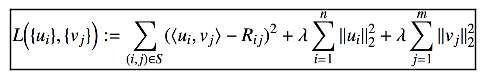

In [17]:
def k_apps_2(M, k):
    U, s, V = np.linalg.svd(M, full_matrices=False)
    S = np.zeros((len(s), len(s)))
    S[:k, :k] = np.diag(s[:k])
    return U, S, V

def train_it(X, _iter=10):
    out_v = []
    _S = np.isfinite(X)
    U, V = k_apps(np.nan_to_num(X), 10)
    for j in range(len(U)):
        out_v.append(np.outer(U[j], U[j]))
    out_u = []
    for j in range(len(V)):
        out_u.append(np.outer(V[j], V[j]))
    for i in range(_iter):
        # U
        for k in range(len(U)):
            f = sum([out_u[j] for j in range(len(V)) if _S[k,j]])
            f += _lambda*np.eye(len(f))
            s = sum([V[j]*X[k,j] for j in range(len(V)) if _S[k,j]])
            U[k] = np.linalg.inv(f).dot(s)

        # V
        for k in range(len(V)):
            f = sum([out_v[j] for j in range(len(U)) if _S[j,k]])
            f += _lambda*np.eye(len(f))
            s = sum([U[j]*X[j,k] for j in range(len(U)) if _S[j,k]])
            V[k] = np.linalg.inv(f).dot(s)
    return np.dot(U,V)

## Visualizing